In [19]:
import os
import tensorflow as tf
import numpy as np
import math
import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
def load_satellite(num_training=4035, num_validation=400, num_test=2000):
    train = np.loadtxt('data/sat_train.txt')
    test = np.loadtxt('data/sat_test.txt')
    np.random.seed(0)
    np.random.shuffle(train)
    np.random.shuffle(test)

    X_train, y_train = train[:,:36],train[:,-1].astype(int)
    X_train = scale(X_train, np.min(X_train, axis=0), np.max(X_train, axis=0))
    
    
    X_test, y_test = test[:, :36], test[:,36].astype(int)
    X_test = scale(X_test, np.min(X_test, axis=0), np.max(X_test, axis=0))
    
    y_train[y_train == 7] = 6
    y_train -= 1
    
    y_test[y_test == 7] = 6
    y_test -= 1
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_satellite()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4035, 36)
Train labels shape:  (4035,) int64
Validation data shape:  (400, 36)
Validation labels shape:  (400,)
Test data shape:  (2000, 36)
Test labels shape:  (2000,)


In [4]:
class Dataset(object):
    def __init__(self, X, y, batch_size=32, shuffle=True):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.seed(0)
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=32, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=32, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=32)

In [5]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /cpu:0


In [6]:
def check_accuracy(sess, dset, x, scores, is_training=None, verbose=False):
    """
    Check accuracy on a classification model.
    
    Inputs:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

In [7]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1, verbose=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during training
    """
    tf.reset_default_graph()    
    with tf.device(device):
        # Construct the computational graph we will use to train the model. We
        # use the model_init_fn to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(tf.float32, [None, 36])
        y = tf.placeholder(tf.int32, [None])
        
        # We need a place holder to explicitly specify if the model is in the training
        # phase or not. This is because a number of layers behaves differently in
        # training and in testing, e.g., dropout and batch normalization.
        # We pass this variable to the computation graph through feed_dict as shown below.
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        # Use the model function to build the forward pass.
        scores = model_init_fn(x, is_training)

        # Compute the loss like we did in Part II
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)

        # Use the optimizer_fn to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.
        
        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.
        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)

    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the
    # model to update.
    errors = []
    accuracies = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
#             print('Starting epoch %d' % epoch)
            for x_np, y_np in train_dset:
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                t += 1                
            accuracy = check_accuracy(sess, val_dset, x, scores, is_training=is_training)
            errors.append(loss_np)
            accuracies.append(accuracy)
        if verbose:
            print('Iteration %d, loss = %.4f' % (t, loss_np))
            print()
    return errors, accuracies


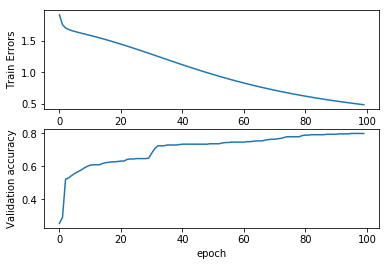

In [34]:
learning_rate = 1e-2
regularizer = tf.contrib.layers.l2_regularizer(scale=10e-3)
num_epoch = 100
hidden_size = 10
num_classes = 6
def model_init_fn(inputs, is_training):
    initializer = tf.variance_scaling_initializer(scale=1.0, seed=0)
    layers = [
        tf.layers.Dense(hidden_size, activation=tf.nn.sigmoid,
                        kernel_regularizer=regularizer,
                        kernel_initializer=initializer),
        tf.layers.Dense(num_classes,
                        kernel_regularizer=regularizer,
                        kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

errors, accuracies = train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epoch)
# print(errors, accuracies)

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
ax1.plot(range(len(errors)), errors)
ax2.plot(range(len(accuracies)), accuracies)
plt.xlabel('epoch')
ax1.set_ylabel('Train Errors')
ax2.set_ylabel('Validation accuracy')
plt.show()

In [9]:
def plot_err_acc(err, acc, hyperparam, label):
    n = len(hyperparam)
    num_epoch = len(err[0])
    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1) 
    for i in range(n):
        ax1.plot(range(num_epoch), err[i], label='{} = {}'.format(label, hyperparam[i]))
        ax2.plot(range(num_epoch), acc[i], label='{} = {}'.format(label, hyperparam[i]))

    plt.xlabel('epoch')
    ax1.set_ylabel('Train Errors')
    ax2.set_ylabel('Validation accuracy')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [10]:
def plot_time(times, hyperparam, label):
    plt.figure()
    plt.plot(hyperparam, times)
    plt.scatter(hyperparam, times)
    plt.xlabel(label)
    plt.ylabel('time')
    for i, time in enumerate(times):
        plt.annotate("%.3f"%(time), (hyperparam[i], times[i]))
    plt.show()

batch size: 4
batch size: 8
batch size: 16
batch size: 32
batch size: 64


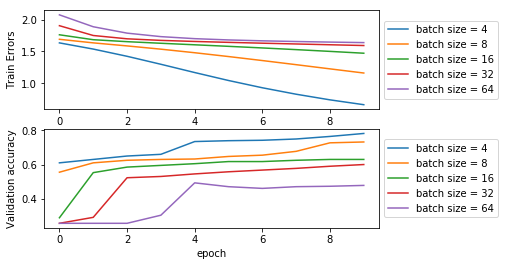

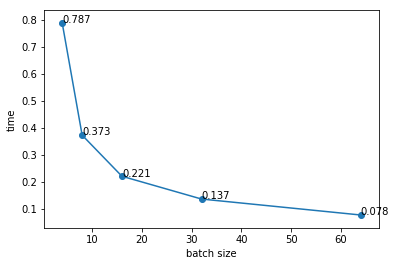

In [21]:
batch_sizes = [4, 8, 16, 32, 64]
num_epoch = 10
acc = []
err = []
times = []
for size in batch_sizes:
    print('batch size:', size)
    train_dset = Dataset(X_train, y_train, batch_size=size, shuffle=True)
    val_dset = Dataset(X_val, y_val, batch_size=size, shuffle=True)
    test_dset = Dataset(X_test, y_test, batch_size=size)
    tic = time.time()
    errors, accuracies = train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epoch)
    toc = time.time()
    acc.append(accuracies)
    err.append(errors)
    times.append((toc - tic)/num_epoch)
plot_err_acc(err, acc, batch_sizes, 'batch size')
plot_time(times, batch_sizes, 'batch size')

hidden size: 5
hidden size: 10
hidden size: 15
hidden size: 20
hidden size: 25


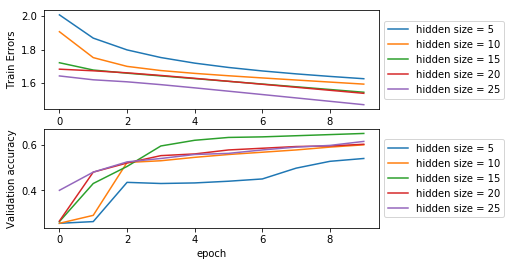

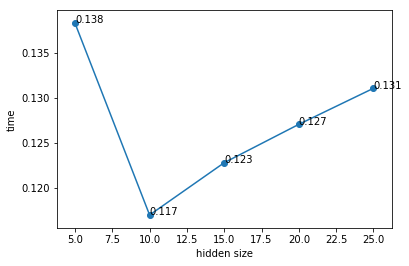

In [26]:
train_dset = Dataset(X_train, y_train, batch_size=32, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=32, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=32)

hidden_sizes = [5, 10, 15, 20, 25]
num_epoch = 10
acc = []
err = []
times = []
for size in hidden_sizes:
    print('hidden size:', size)
    hidden_size = size
    tic = time.time()
    errors, accuracies = train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epoch)
    toc = time.time()
    acc.append(accuracies)
    err.append(errors)
    times.append((toc - tic)/num_epoch)
plot_err_acc(err, acc, hidden_sizes, 'hidden size')
plot_time(times, hidden_sizes, 'hidden size')

decay: 0.01
decay: 1e-05
decay: 1e-08
decay: 1e-11
[[1.9060364, 1.7517004, 1.6994642, 1.6746286, 1.6577349, 1.6435848, 1.6305918, 1.6181387, 1.6059154, 1.5937299, 1.5814518, 1.5689882, 1.5562748, 1.5432686, 1.5299474, 1.5163034, 1.5023426, 1.4880781, 1.4735299, 1.4587193, 1.4436684, 1.4283977, 1.4129263, 1.3972712, 1.3814478, 1.36547, 1.3493528, 1.3331105, 1.3167578, 1.3003114, 1.2837883, 1.2672068, 1.250586, 1.2339457, 1.217306, 1.2006861, 1.1841062, 1.1675844, 1.1511391, 1.1347867, 1.1185434, 1.1024228, 1.0864385, 1.0706018, 1.0549227, 1.0394107, 1.0240736, 1.0089184, 0.9939502, 0.9791743, 0.9645948, 0.95021564, 0.93603915, 0.92206764, 0.90830374, 0.89474773, 0.8814018, 0.8682666, 0.8553416, 0.8426283, 0.830126, 0.8178347, 0.8057539, 0.7938826, 0.7822199, 0.7707649, 0.7595156, 0.748471, 0.7376292, 0.7269881, 0.7165454, 0.70629907, 0.6962468, 0.68638563, 0.6767133, 0.667227, 0.6579235, 0.6488003, 0.63985467, 0.6310826, 0.62248236, 0.6140495, 0.6057821, 0.5976765, 0.5897301, 0.5819388,

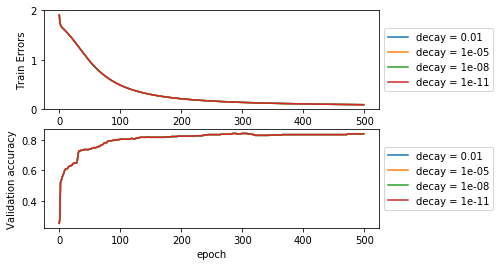

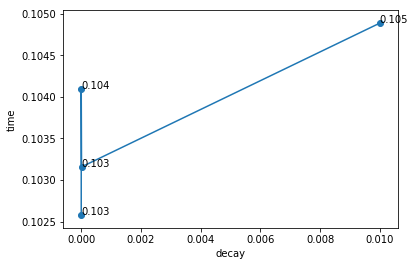

In [35]:
decay_params = [10e-3, 10e-6, 10e-9, 10e-12]
num_epoch = 500
acc = []
err = []
times = []
for decay in decay_params:
    print('decay:', decay)
    regularizer = tf.contrib.layers.l2_regularizer(scale=decay)
    tic = time.time()
    errors, accuracies = train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epoch)
    toc = time.time()
    acc.append(accuracies)
    err.append(errors)
    times.append((toc - tic)/num_epoch)
plot_err_acc(err, acc, decay_params, 'decay')
plot_time(times, decay_params, 'decay')